<a href="https://colab.research.google.com/github/ese-msc-2021/acds-day-after-tomorrow-ivan/blob/main/Conv_LSTM_Hurricane_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This File contains a combination of two files :

PART 1 : This is the implementation demo of of the Convolutional LSTM for Image Prediction on our demo Dataset

[PART 2](#PART-2-:-Hurricane-Prediction-for-Surprise-Storm) : Here, you wil find the results of the surprise storm trained using the convoltuional LSTM

# **PART 1 : Hurricane Prediction : Next Frame Generation using Convolutional Long Short Term Memory**

### **Index and HyperParameter Update Links**

- [Imports and Installations](#Imports-and-Installations)
    - Update API Key
    - Update Download Directory
    - Update Initialize download labels to the data

- [Downloding the Data and Extracting the Files](#Downloding-the-Data-and-Extracting-the-Files)

- [Selecting the Storm](#Selecting-the-Storm)

- [Training and Validation Split](#Training-and-Validation-Split)

- [Data Transformations and Preprocessing](#Data-Transformations-and-Preprocessing)
    - Update the number of frames
    - Update Images to predict

- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

- [The Convolutional LSTM Model](#The-Convolutional-LSTM-Model)


- [Loading the Data in DataLoaders](#Loading-the-Data-in-DataLoaders)

- [Train the Model](#Train-the-Model)

- [Initialize the Model with the Chosen Hyperparameters](#Initialize-the-Model-with-the-Chosen-Hyperparameters)

- [Preparing Test Data](#Preparing-Test-Data)

- [Preparing and Calculating Output](#Preparing-and-Calculating-Output)

- [Calculation of Final Metrics](#Calculation-of-Final-Metrics)


** Note the parameters you need to update will be marked with an !! UPDATE HERE !!

### **Imports and Installations** 

In [ ]:
!pip install livelossplot pycm radiant_mlhub torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount the folders to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing required modules and packages
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# Import Plotting packages 
from livelossplot import PlotLosses
from pycm import *
import seaborn as sns
import matplotlib.pyplot as plt
import math


# Import torch packages that help us define and run our network 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.transforms import Normalize
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder

# Package that allows us to summarize our network
from torchsummary import summary
# package that allows us to measure the metrics
from torchmetrics import StructuralSimilarityIndexMeasure

# Import image manipulation package 
from PIL import Image

# Importting numerical and dataframe management packages
import numpy as np
import pandas as pd
import random

# File Manipulation Imports
import os
import json
import re
from glob import glob
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt

# Import packages from the downloaded target data package
from radiant_mlhub import Dataset, Collection, client

# Packages for the metrics for the image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from pathlib import Path
from PIL import Image
import numpy as np


In [ ]:
# Selecting the devide to train on
device = 'gpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cpu'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### **Downloding the Data and Extracting the Files**

In [ ]:
# ---------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# ---------------------------------------------------------------------------------------
# API KEy for the dataset import
os.environ['MLHUB_API_KEY'] = '5c52777a30471a1c9695fa1be6fa528a26eb2a65e57c202febd53504539d5010'

In [ ]:
# Get the required dataset from a path 
dataset = Dataset.fetch('nasa_tropical_storm_competition')

In [ ]:
# ---------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                      
# ---------------------------------------------------------------------------------------
# Use this to download to a data folder the current working directory
download_dir = Path('./data').resolve()

In [ ]:
# Set the archive paths to the downlaod path
archive_paths = dataset.download(output_dir=download_dir)

In [ ]:
# ---------------------------------------------------------------------------------------------------
# EXTRACT TAR FILES AND SAVE THE PATH
# ---------------------------------------------------------------------------------------------------
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

Extracting /content/data/nasa_tropical_storm_competition_train_source.tar.gz...
Extracting /content/data/nasa_tropical_storm_competition_test_source.tar.gz...
Extracting /content/data/nasa_tropical_storm_competition_train_labels.tar.gz...
Extracting /content/data/nasa_tropical_storm_competition_test_labels.tar.gz...
Done


In [ ]:
# ---------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# ---------------------------------------------------------------------------------------
# Initialize download labels to the data
train_source = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'
test_source = 'nasa_tropical_storm_competition_test_source'

In [ ]:
# ---------------------------------------------------------------------------------------------------
# EXTRACT AND SAVE THE DATA IN A DATAFRAME
# ---------------------------------------------------------------------------------------------------
train_data = []


# ---------------------------------------------------------------------------------------------------
# Save the jpeg train file names
jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

# ---------------------------------------------------------------------------------------------------
# Get the features data from the paths
for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)

# ---------------------------------------------------------------------------------------------------
    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed'])
    ])
# ---------------------------------------------------------------------------------------------------
# Save the train data in a Pandas dataframe
train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image_ID', 'Storm_ID', 'Relative_Time', 'Ocean', 'Wind_Speed']
).sort_values(by=['Image_ID']).reset_index(drop=True)


# ---------------------------------------------------------------------------------------------------
# Saving the Test Data in a Dataframe
test_data = []



# ---------------------------------------------------------------------------------------------------
# Save the jpeg test file names
jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

# ---------------------------------------------------------------------------------------------------
for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
    ])
# ---------------------------------------------------------------------------------------------------
# Save the test dataframe
test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image_ID', 'Storm_ID', 'Relative_Time', 'Ocean']
).sort_values(by=['Image_ID']).reset_index(drop=True)



In [ ]:
# ---------------------------------------------------------------------------------------------------
# Add the image paths to the datafame
train_df["image_paths"] = glob(str(download_dir / train_source / '**' / '*.jpg'))
test_df["image_paths"] = glob(str(download_dir / test_source / '**' / '*.jpg'))


## **Selecting the Storm**

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Find the storm with the highest Samples
valid_storms = train_df.groupby('Storm_ID').count()
# Sort storms by sample count
valid_storms.sort_values('Image_ID', ascending = False)

,Image_ID,Relative_Time,Ocean,Wind_Speed,image_paths
Storm_ID,,,,,
fcr,648,648,648,648,648
xjo,617,617,617,617,617
ywf,614,614,614,614,614
psz,576,576,576,576,576
ing,527,527,527,527,527
...,...,...,...,...,...
smj,10,10,10,10,10
vfp,9,9,9,9,9
qvp,6,6,6,6,6


In [ ]:
# ---------------------------------------------------------------------------------------------------
# Picking the Storm with the highest 
train_fcr = train_df[train_df["Storm_ID"] == "fcr"]
test_fcr = test_df[train_df["Storm_ID"] == "fcr"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


## **Exploratory Data Analysis**

## **Training and Validation Split**

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Find the Training and Validation Split for the FCR Storm : Splitting the Data 80:20 
# 80% - Training Data and 20% - Validation Data
train_count = int(np.floor(len(train_fcr)*.8))
val_count = len(train_fcr) - train_count

## **Data Transformations and Preprocessing**

In [ ]:
# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# -------------------------------------------------------------------------------------------------
# Define the resizing value
resize_value = 64

In [ ]:
# ---------------------------------------------------------------------------------------------------
# DATA TRANSFORMATIONS : Creating the transforms for the Data
# ---------------------------------------------------------------------------------------------------
#   The Transforms Include :
# - Converting the Data to Grayscale with 1 channel ( from 3 RGB channels to 1 channel )
# - Resizing the data to 64x64 for training purposes
# - Transform the data to a list of tensors for future ease of manipulations

# Define the transform
transform_data = transforms.Compose([transforms.Grayscale(1),transforms.ToTensor(),transforms.Resize(resize_value)])



In [ ]:
# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# --------------------------------------------------------------------------------------------------
# Immport the Images using ImageFolder Dataset and apply the defined transforms
train_set_folder = ImageFolder('./data/nasa_tropical_storm_competition_train_source/', transform=transform_data)
test_set_folder = ImageFolder('./data/nasa_tropical_storm_competition_test_source/', transform=transform_data)

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Save the Training Data
# ---------------------------------------------------------------------------------------------------
x_train = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_fcr.index)[:train_count]])
# ---------------------------------------------------------------------------------------------------
# Save the Validtion Data
# ---------------------------------------------------------------------------------------------------
x_val  = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_fcr.index)[train_count:]])
# ---------------------------------------------------------------------------------------------------
# Save the Testing Data
# ---------------------------------------------------------------------------------------------------
x_test  = torch.asarray([test_set_folder[a][0].numpy() for a in list(test_fcr.index)])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  after removing the cwd from sys.path.


In [ ]:
# --------------------------------------------------------------------------
# DATA PREPROCESSING : NUMBER OF SEQUENCES/FRAMES TO CONSIDER AT A TIME
# --------------------------------------------------------------------------

# Define the number of frames to consider at a time
frames = 10

# Reshaping parameter
x1 = int(x_train.shape[0]/frames)
x2 = int(x_val.shape[0]/frames)
x3 = int(x_test.shape[0]/frames)


# Reshape the training, test and validation data
x1_reshaped = x_train[:x1*frames]
x2_reshaped = x_val[:x2*frames]
x3_reshaped = x_test[:x3*frames]

# Print the intermediate reshaped sizes to verify that the images are reaized as required
# print(x1_reshaped.shape)
# print(x2_reshaped.shape)
# print(x3_reshaped.shape)

# Final reshaping of the data to fit the number of frames
x_train = x1_reshaped.reshape(-1, frames, x_train.shape[2], x_train.shape[3])
x_val = x2_reshaped.reshape(-1, frames, x_val.shape[2], x_val.shape[3])
x_test = x3_reshaped.reshape(-1, frames, x_test.shape[2], x_test.shape[3])

# Print final reshaped sizes to verify that the images are resized as required
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)


torch.Size([51, 10, 64, 64])
torch.Size([64, 10, 64, 64])
torch.Size([13, 10, 64, 64])


In [ ]:
# The number of Images you want to predict
images_to_predict = int(5)

In [ ]:
# --------------------------------------------------------------------------
# DATA PREPROCESSING : CREATE BATCHES FOR EACH SET OF FRAMES
# --------------------------------------------------------------------------
# We use the collate function to create input and target batches 
# The input batch selects first five inputs of each sequence to predict the 
# next 5 sequences in the data.

def collate(batch):
    # Add channel dimension
    batch = torch.tensor(batch).unsqueeze(1)     
    # batch = batch / 255.0   
    # Send the input and targets from the batch to the GPU                  
    batch = batch.to(device)                     

    # Pick the first 5 frames as input and the predict the next 5 frames                   
    return batch[:,:,0:images_to_predict], batch[:,:,images_to_predict]  

## **The Convolutional LSTM Model**

#### Functions in the Convolutional LSTM Model

- The Convolutional LSTM Cell
- The Sequence to Sequence Function
- The Convoltuional LSTM function



The code for this model is heavily influenced by the following sources ⁉

[1] [Video Frame Prediction using ConvLSTM Network in PyTorch, Medium Article](#https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582)

[2] [Convolutional LSTM in Pytorch, Github Repository](#https://github.com/ndrplz/ConvLSTM_pytorch)

[3] [ConvLSTM cell, Shi et al.](#https://paperswithcode.com/paper/convolutional-lstm-network-a-machine-learning#code)


### **Sequence to Sequence Function**

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Sequence to Sequence Function
# ---------------------------------------------------------------------------------------------------
class Seq2Seq(nn.Module):
    # --------------------------------------------------------------------------
    # Initialization Function 
    # --------------------------------------------------------------------------
    # Number of Channels 
    # Number of Kernals
    # Kernal Size
    # Padding
    # Activation Function
    # Frame Size
    # Number of ConvLSTM Layers

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):
        # Supercharge the Model
        super(Seq2Seq, self).__init__()
        # Define the sequential function for the network
        self.sequential = nn.Sequential()

        # -----------------------------------------------------------------------------
        # SECTION 1 : Define First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )
        # Add Consequitive Batch Normaliation for Regularization of the Data
        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # -----------------------------------------------------------------------------
        # SECTION 2 : Define the rest of the layers using a loop for ease
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
            # Add Batch Normaliation for Regularization of the Data    
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 
            
        # -----------------------------------------------------------------------------
        # SECTION 3 : Define Final Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Define the forward pass through all the layers
        output = self.sequential(X)

        # Return only the last output frame of the predicted set
        output = self.conv(output[:,:,-1])

        return output

### **Convolutional LSTM Cell**

In [ ]:
class ConvLSTMCell(nn.Module):
    # --------------------------------------------------------------------------
    # Initialization Function 
    # --------------------------------------------------------------------------
    # Number of  input channels 
    # Number of  output channels s
    # Kernal Size
    # Padding
    # Activation Function
    # Frame Size
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):
        # Supercharge the Model
        super(ConvLSTMCell, self).__init__()  

        # Depending on the selected activation function- define the input
        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Adapted from Reference[2]
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           
        # --------------------------------------------------------------------------
        # Initialize weights for Hadamard Products 
        # --------------------------------------------------------------------------
        # Initialize Input weights
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        # Initialize Output weights
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        # Initialize forget weights
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        # --------------------------------------------------------------------------
        # Forward Function 
        # --------------------------------------------------------------------------
        # Adapted from Reference[2]
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Adapted from Reference[2]
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        # Actiavte the input and forget gate with a sigmoid function (a leaky switch)
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output is added to the input gate
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        # Activate the output gate using the sigmoid function
        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Initialize the Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

### **Convolutional LSTM Network**

In [ ]:

class ConvLSTM(nn.Module):
    # --------------------------------------------------------------------------
    # Initialization Function 
    # --------------------------------------------------------------------------
    # Number of  input channels 
    # Number of  output channels
    # Kernal Size
    # Padding
    # Activation Function
    # Frame Size
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        # SuperCharge the Model
        super(ConvLSTM, self).__init__()
        # Define the number of output channels
        self.out_channels = out_channels

        # Single LSTM Cell - to be rolled over time
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):
        # --------------------------------------------------------------------------
        # Forward Function 
        # --------------------------------------------------------------------------
        # X is a frame sequence 
        # X is defined in the order - batch_size, num_channels, seq_len, height, width 

        # Unravel the required parameters
        batch_size, _, seq_len, height, width = X.size()

        # Initialize a tensor output with zeros 
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize a tensor Hidden State with zeros
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize tensor Cell Input with zeros
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Load over the time sequence of the model - is the number of frames
        for time_step in range(seq_len):
            H, C = self.convLSTMcell(X[:,:,time_step], H, C)
            output[:,:,time_step] = H

        return output

## **Loading the Data in DataLoaders**

In [ ]:
# Training Data Loader
train_loader = DataLoader(np.asarray(x_train), shuffle=False, batch_size=8, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(np.asarray(x_val), shuffle=False, batch_size=8, collate_fn=collate)

In [ ]:
# --------------------------------------------------------------------------
# Get a batch from the vadiation loader to verify correct inputs
# --------------------------------------------------------------------------
input, _ = next(iter(val_loader))

## **Initialize the Model with the Chosen Hyperparameters**

We found that while the convolutional lstm is a sensible choice for this case, it was a difficult task to tune the hyperparamters sensibly.

Finally the parameters selectd include:

Learning Rate : 0.0001 \
Batch Size (for Data Loader) : 8 \
Number of Kernals for the Convoltuional Layers : 64 \
Number of Convoltuional LSTM Layers : 6 (or 10!) \
Number of Training Epochs : 

Further the optimizer chosen was Adam and the loss criterion was the MSE loss which is suitable for our model

In [ ]:
# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# --------------------------------------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------
# Selection of Hyper Parameters
# -------------------------------------------------------------------------------

# Number of kernals 
n_k = 64

# Actiavtion function
act = "relu"

# Number of Convolutional LSTM layers
conv_lstm_layers = 6

# Define the number of Epochs
num_epochs = 30


In [ ]:
# -------------------------------------------------------------------------------
# Instantiate the model and send the model to the device
# -------------------------------------------------------------------------------
model = Seq2Seq(num_channels=1, num_kernels=n_k, 
kernel_size=(3, 3), padding=(1, 1), activation=act, 
frame_size=(resize_value, resize_value), num_layers=conv_lstm_layers).to(device)


In [ ]:
# -------------------------------------------------------------------------------
# Define the Model HyperParameters
# -------------------------------------------------------------------------------

# Define the optimize
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define the Criterion as the Mean Squared Error Loss
criterion = nn.MSELoss()


In [ ]:
def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

## **Train the Model**

In [ ]:
# Arrays to save the training and validation losses
train_loss_list = []
val_loss_list = []



for epoch in range(1, num_epochs+1):
    # ------------------------------------------------------------------------------
    #  TRAINING 
    # ------------------------------------------------------------------------------

    # Rest the train loss for the new epoch
    train_loss = 0      

    # Set the model to train                                             
    model.train()  

    # Train the model for each input batch
    # Each input batch consists of 10 sequences
    # 5 input images are used to predict the next 5 image                                                
    for batch_num, (input, target) in enumerate(train_loader, 1):

        # Forward propogate the model on the input data 
        # for each of the batches  
        output = model(input) 

        # Calcualte the losses for each layer
        loss = criterion(output.flatten(), target.flatten()) 
        # Backward propogate the gradients   
        loss.backward()       
        # Updates the weights in each layer                                     
        optim.step()     
        # Set the computational gradient grid to zero                                          
        optim.zero_grad()   
        # Update the training losses for the current batch                                        
        train_loss += loss.item() 
    # Find the average training loss over the whole batch                                
    train_loss /= len(train_loader.dataset)   

    # -------------------------------------------------------------------------------
    #  VALIDATION 
    # -------------------------------------------------------------------------------
    # Rest the validation loss for the new epoch
    val_loss = 0    
    # Set the model to evaluate                                              
    model.eval() 

    # Prevet the calulation/updates of gradients/weights during evalution                                                  
    with torch.no_grad(): 
      # Run the model for each input batch                                         
        for input, target in val_loader:   
           # Forward propogate the model on the input data 
            # for each of the batches                       
            output = model(input)  
            # Backward propogate the gradients                      
            loss = criterion(output.flatten(), target.flatten())  
            # Update the validaation losses for the current batch 
            val_loss += loss.item()  

    # Find the average validation loss over the whole batch 
    val_loss /= len(val_loader.dataset) 

    # Save the training and validation losses
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # Display the training and validation loss for each epoch
    # Display the SSIM and MSE Loss for Each epoch
   
    print("Epoch:{} Training Loss:{:.6f} Validation Loss:{:.6f}\n".format(
        epoch, train_loss, val_loss))



Epoch:1 Training Loss:0.060873 Validation Loss:0.002661

Epoch:2 Training Loss:0.019723 Validation Loss:0.003435

Epoch:3 Training Loss:0.008858 Validation Loss:0.004572

Epoch:4 Training Loss:0.004595 Validation Loss:0.006374

Epoch:5 Training Loss:0.003188 Validation Loss:0.007546

Epoch:6 Training Loss:0.002531 Validation Loss:0.006187

Epoch:7 Training Loss:0.001956 Validation Loss:0.002797

Epoch:8 Training Loss:0.001801 Validation Loss:0.001282

Epoch:9 Training Loss:0.001584 Validation Loss:0.001545

Epoch:10 Training Loss:0.001467 Validation Loss:0.001411

Epoch:11 Training Loss:0.001368 Validation Loss:0.002618

Epoch:12 Training Loss:0.001305 Validation Loss:0.005361

Epoch:13 Training Loss:0.001241 Validation Loss:0.002624

Epoch:14 Training Loss:0.001191 Validation Loss:0.000840

Epoch:15 Training Loss:0.001149 Validation Loss:0.000484

Epoch:16 Training Loss:0.001117 Validation Loss:0.000368

Epoch:17 Training Loss:0.001085 Validation Loss:0.000331

Epoch:18 Training Loss:

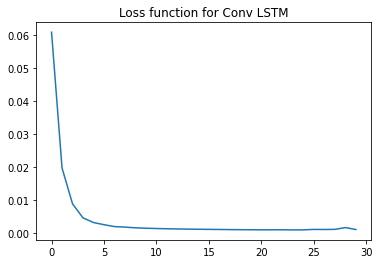

In [ ]:
# The evoltuion of the Loss over the epochs - Training Data
fig, axs = plt.subplots(1,1)
axs.set_title("Loss function for Conv LSTM")
axs.plot(train_loss_list,)

We observe that the training loss is steadily low after the first 6-10 epochs

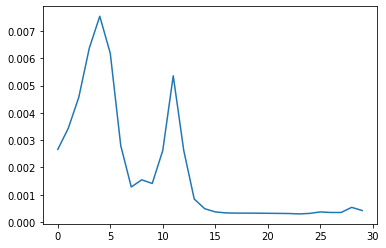

In [ ]:
# The evoltuion of the Loss over the epochs - Validation Data
plt.plot(val_loss_list)

We observe that after the 15th epoch the validation loss stops being erratic and settles into a steady value

## **Preparing Test Data**

In [ ]:
# -------------------------------------------------------------------------------
#  COLLATE DATA INTO BATCHS FOR TESTING 
# -------------------------------------------------------------------------------
def collate_test(batch):

    # Last 5 frames are te target
    target = np.array(batch)[:,images_to_predict:]                     

    # Add channel dim
    batch = torch.tensor(batch).unsqueeze(1)       

    # Send batch to the GPU                            
    batch = batch.to(device)                          
    return batch, target

# -------------------------------------------------------------------------------
# Test Data Loader
# -------------------------------------------------------------------------------
test_loader = DataLoader(np.asarray(x_test),shuffle=False, 
                         batch_size=1, collate_fn=collate_test)


In [ ]:
# -------------------------------------------------------------------------------
# Verify correct loading by getting a batch of data
# -------------------------------------------------------------------------------
batch, target = next(iter(test_loader))



## **Preparing and Calculating Output**

In [ ]:
# -------------------------------------------------------------------------------
# Initialize output sequence
# -------------------------------------------------------------------------------
output = np.zeros(target.shape, dtype=np.float64)


In [ ]:
# -------------------------------------------------------------------------------
# TEST OUTPUT CALCULATION
# -------------------------------------------------------------------------------

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+images_to_predict]  
  output[:,timestep]=model(input).squeeze(1).cpu().detach()

## **Plot Image Predictions**

### **First Prediction**

 Input :

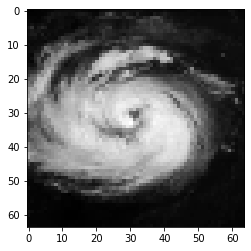

In [ ]:
plt.imshow(input[0][0][0], cmap = 'gray')

Output :

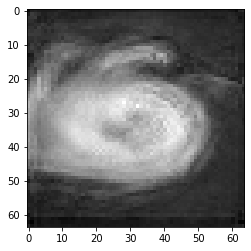

In [ ]:
plt.imshow(output[0][0], cmap = 'gray')

### **Second Prediction**

Input:

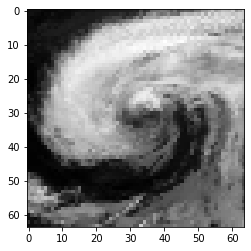

In [ ]:
plt.imshow(input[0][0][1], cmap = 'gray')

Output:


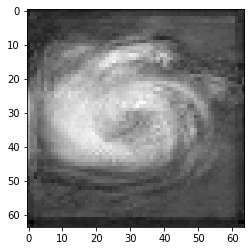

In [ ]:
plt.imshow(output[0][1], cmap = 'gray')

### **Third Prediction**

Input:


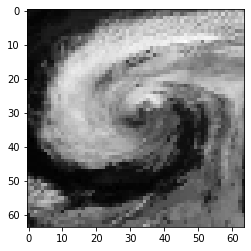

In [ ]:
plt.imshow(input[0][0][2], cmap = 'gray')

Output:

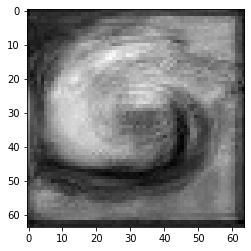

In [ ]:
plt.imshow(output[0][2], cmap = 'gray')

### **Fourth Prediction**

Input:

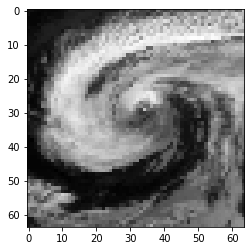

In [ ]:
plt.imshow(input[0][0][3], cmap = 'gray')

Output:

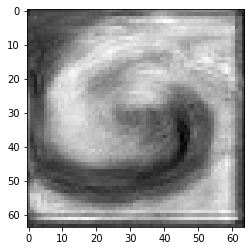

In [ ]:
plt.imshow(output[0][3], cmap = 'gray')

### **Fifth Prediction**

Input :

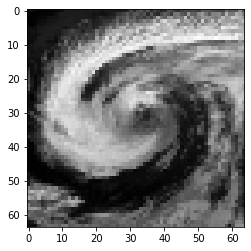

In [ ]:
plt.imshow(input[0][0][4], cmap = 'gray')

Output:

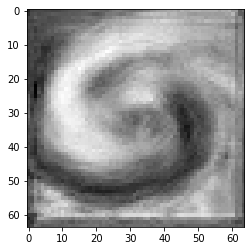

In [ ]:
plt.imshow(output[0][4], cmap = 'gray')

## **Calculation of Final Metrics**

In [ ]:
# ------------------------------------------------------------------------------
# Load target images for comparison
# ------------------------------------------------------------------------------

target_1 = input[0][0][-5].cpu().detach().numpy()*255
target_2 = input[0][0][-4].cpu().detach().numpy()*255
target_3 = input[0][0][-3].cpu().detach().numpy()*255
target_4 = input[0][0][-2].cpu().detach().numpy()*255
target_5 = input[0][0][-1].cpu().detach().numpy()*255

predic_1 = output[0][-5]*255
predic_2 = output[0][-4]*255
predic_3 = output[0][-3]*255
predic_4 = output[0][-2]*255
predic_5 = output[0][-1]*255

# ------------------------------------------------------------------------------
# Scale predicted image to target range
# ------------------------------------------------------------------------------
predic_1 = scale2range(predic_1, [target_1.min(), target_1.max()])
predic_2 = scale2range(predic_2, [target_2.min(), target_2.max()])
predic_3 = scale2range(predic_3, [target_3.min(), target_3.max()])
predic_4 = scale2range(predic_4, [target_4.min(), target_4.max()])
predic_5 = scale2range(predic_5, [target_5.min(), target_5.max()])

# ------------------------------------------------------------------------------
# Cast to uint8 to accommodate for consistent SSIM and MSE results
# ------------------------------------------------------------------------------
target_1, predic_1 = target_1.astype(np.uint8), predic_1.astype(np.uint8)
target_2, predic_2 = target_2.astype(np.uint8), predic_2.astype(np.uint8)
target_3, predic_3 = target_3.astype(np.uint8), predic_3.astype(np.uint8)
target_4, predic_4 = target_4.astype(np.uint8), predic_4.astype(np.uint8)
target_5, predic_5 = target_5.astype(np.uint8), predic_5.astype(np.uint8)

# ------------------------------------------------------------------------------
# Sanity check
# ------------------------------------------------------------------------------
print(target_1.dtype, target_1.max(), target_1.min())
print(predic_1.dtype, predic_1.max(), predic_1.min())

# ------------------------------------------------------------------------------
# Compute metrics
# ------------------------------------------------------------------------------
print('\n ---------- SSIM and MSE values -------------- \n')
s_1, m_1 = ssim(target_1, predic_1), mse(target_1, predic_1)
s_2, m_2 = ssim(target_2, predic_2), mse(target_2, predic_2)
s_3, m_3 = ssim(target_3, predic_3), mse(target_3, predic_3)
s_4, m_4 = ssim(target_4, predic_4), mse(target_4, predic_4)
s_5, m_5 = ssim(target_5, predic_5), mse(target_5, predic_5)

# ------------------------------------------------------------------------------
print("First Prdiction : SSIM : ",s_1," MSE : ",m_5)
print("Second Prdiction : SSIM : ",s_2," MSE : ",m_4)
print("Third Prdiction : SSIM : ",s_3," MSE : ",m_3)
print("Fourth Prdiction : SSIM : ",s_4," MSE : ",m_2)
print("Fifth Prdiction : SSIM : ",s_5," MSE : ",m_1)

uint8 209 4
uint8 209 4

 ---------- SSIM and MSE values -------------- 

First Prdiction : SSIM :  0.5827536298329827  MSE :  1128.365478515625
Second Prdiction : SSIM :  0.3140424828366407  MSE :  1139.0517578125
Third Prdiction : SSIM :  0.4949727294815224  MSE :  726.66259765625
Fourth Prdiction : SSIM :  0.4600275734313387  MSE :  2010.955078125
Fifth Prdiction : SSIM :  0.5177025544355225  MSE :  562.16943359375




---



---

# **PART 2 : Hurricane Prediction for Surprise Storm**



---



---



### **Index and HyperParameter Update Links**

- [Imports and Installations](#Imports-and-Installations)
    - Update API Key
    - Update Download Directory
    - Update Initialize download labels to the data

- [Downloding the Data and Extracting the Files](#Downloding-the-Data-and-Extracting-the-Files)

- [Selecting the Storm](#Selecting-the-Storm)

- [Training and Validation Split](#Training-and-Validation-Split)

- [Data Transformations and Preprocessing](#Data-Transformations-and-Preprocessing)
    - Update the number of frames
    - Update Images to predict

- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

- [The Convolutional LSTM Model](#The-Convolutional-LSTM-Model)


- [Loading the Data in DataLoaders](#Loading-the-Data-in-DataLoaders)

- [Train the Model](#Train-the-Model)

- [Initialize the Model with the Chosen Hyperparameters](#Initialize-the-Model-with-the-Chosen-Hyperparameters)

- [Preparing Test Data](#Preparing-Test-Data)

- [Preparing and Calculating Output](#Preparing-and-Calculating-Output)

- [Calculation of Final Metrics](#Calculation-of-Final-Metrics)


** Note the parameters you need to update will be marked with an !! UPDATE HERE !!

In [ ]:
!pip install livelossplot pycm radiant_mlhub torchmetrics scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 4.6 MB/s 
     |████████████████████████████████| 409 kB 40.2 MB/s 
     |████████████████████████████████| 793 kB 67.9 MB/s 
     |████████████████████████████████| 381 kB 98.1 MB/s 
     |████████████████████████████████| 590 kB 57.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 137 kB 93.2 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing required modules and packages
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# Import Plotting packages 
from livelossplot import PlotLosses
from pycm import *
import seaborn as sns
import matplotlib.pyplot as plt


# Import torch packages that help us define our network

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.transforms import Normalize
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder

# Package that allows us to summarize our network
from torchsummary import summary

# Import image manipulation package 
from PIL import Image

# Importting numerical and dataframe management packages
import numpy as np
import pandas as pd
import random

# Packages to make a deep copy of our model 
from copy import deepcopy


# File Manipulation Imports
import os
import json
import re
from glob import glob
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
from radiant_mlhub import Dataset, Collection, client
from torchmetrics import StructuralSimilarityIndexMeasure

# Packages for the metrics for the image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from pathlib import Path
from PIL import Image
import numpy as np



In [ ]:
# ---------------------------------------------------------------------------------------------------
# Selecting the devide to train on
# ---------------------------------------------------------------------------------------------------

device = 'gpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cpu'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### **Downloding the Data and Extracting the Files**

In [ ]:
# ---------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# ---------------------------------------------------------------------------------------
# Set path sources in the folders
path_source = "/content/nasa_tropical_storm_competition_surprise_storm_source.tar.gz"
path_labels = "/content/nasa_tropical_storm_competition_surprise_storm_labels.tar.gz"

# Set the archive paths to the downlaod path
archive_paths = [path_source, path_labels, path_metrics]

In [ ]:
download_dir = Path("/content").expanduser().resolve()
# ---------------------------------------------------------------------------------------------------
# EXTRACT TAR FILES AND SAVE THE PATH
# ---------------------------------------------------------------------------------------------------
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

Extracting /content/nasa_tropical_storm_competition_surprise_storm_source.tar.gz...
Extracting /content/nasa_tropical_storm_competition_surprise_storm_labels.tar.gz...
Extracting /content/nasa_tropical_storm_competition_surprise_storm_metrics.tar.gz...
Done


In [ ]:
# ---------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# ---------------------------------------------------------------------------------------
train_source = 'nasa_tropical_storm_competition_surprise_storm_source'
train_labels = 'nasa_tropical_storm_competition_surprise_storm_labels'

In [ ]:

train_data = []


# ---------------------------------------------------------------------------------------------------

jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))
# ---------------------------------------------------------------------------------------------------

for jpg_path in jpg_names:
  jpg_path = Path(jpg_path)
  # Get the IDs and file paths
  features_path = jpg_path.parent / 'features.json'
  image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
  storm_id = image_id.split('_')[0]
  labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)
  file_name = jpg_path

  # Load the features data
  with open(features_path) as src:
    features_data = json.load(src)
  # Load the labels data
  with open(labels_path) as src:
    labels_data = json.load(src)

  train_data.append([
  image_id,
  storm_id,
  int(features_data['relative_time']),
  int(features_data['ocean']),
  int(labels_data['wind_speed']),

  file_name
  ])

# ---------------------------------------------------------------------------------------------------
# Save the test dataframe
train_df = pd.DataFrame(
np.array(train_data),
columns=['Image_ID', 'Storm_ID', 'Relative_Time', 'Ocean', 'Wind_Speed', 'image_paths']
).sort_values(by=['Image_ID']).reset_index(drop=True)




In [ ]:
# ---------------------------------------------------------------------------------------------------
# Disply the loaded Data
# ---------------------------------------------------------------------------------------------------

train_df.head()

,Image_ID,Storm_ID,Relative_Time,Ocean,Wind_Speed,image_paths
0,sss_001,sss,437401,1,120,/content/nasa_tropical_storm_competition_surpr...
1,sss_002,sss,439200,1,121,/content/nasa_tropical_storm_competition_surpr...
2,sss_003,sss,442800,1,124,/content/nasa_tropical_storm_competition_surpr...
3,sss_004,sss,448200,1,128,/content/nasa_tropical_storm_competition_surpr...
4,sss_005,sss,453600,1,130,/content/nasa_tropical_storm_competition_surpr...


In [ ]:
train_df["image_paths"] = glob(str(download_dir / train_source / '**' / '*.jpg'))
test_df = train_df
test_df["image_paths"] = glob(str(download_dir / train_source / '**' / '*.jpg'))


### **Edploratory Data Analysis**

In [ ]:
# gauge the Length of the Data
len(train_df)

100

In [ ]:
# Excluding the last 5 storms  - this is the test Data
train_df = train_df[:-5]
# Print the new length of the data
len(train_df)

95

## **Training and Validation Split**

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Find the Training and Validation Split for the FCR Storm : Splitting the Data 80:20 
# 80% - Training Data and 20% - Validation Data
train_count = int(np.floor(len(train_df)*.8))
val_count = len(train_df) - train_count

## **Data Transformations and Preprocessing**

In [ ]:
# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# --------------------------------------------------------------------------------------------------
# Define the resizing value
resize_value = 64

In [ ]:
# ---------------------------------------------------------------------------------------------------
# DATA TRANSFORMATIONS : Creating the transforms for the Data
# ---------------------------------------------------------------------------------------------------
#   The Transforms Include :
# - Converting the Data to Grayscale with 1 channel ( from 3 RGB channels to 1 channel )
# - Resizing the data to 64x64 for training purposes
# - Transform the data to a list of tensors for future ease of manipulations

# Define the transform
transform_data = transforms.Compose([transforms.Grayscale(1),transforms.ToTensor(),transforms.Resize(resize_value)])


In [ ]:
# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# --------------------------------------------------------------------------------------------------
data_path = '/content/nasa_tropical_storm_competition_surprise_storm_source'

def loader(path):
  return open(path)

# ---------------------------------------------------------------------------------------------------
# Immport the Images using ImageFolder Dataset and apply the defined transforms
train_set_folder = ImageFolder(data_path, transform=transform_data)

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Save the Training Data
# ---------------------------------------------------------------------------------------------------
x_train = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_df.index)[:train_count]])
# ---------------------------------------------------------------------------------------------------
# Save the Validtion Data
# ---------------------------------------------------------------------------------------------------
x_val  = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_df.index)[train_count:]])
# ---------------------------------------------------------------------------------------------------
# Save the Testing Data
# ---------------------------------------------------------------------------------------------------
x_test  = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_df.index)])


In [ ]:

# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# --------------------------------------------------------------------------------------------------
# Define the number of frames to consider at a time
frames = 10

In [ ]:
# --------------------------------------------------------------------------
# DATA PREPROCESSING : NUMBER OF SEQUENCES/FRAMES TO CONSIDER AT A TIME
# --------------------------------------------------------------------------
# Reshaping parameter
x1 = int(x_train.shape[0]/frames)
x2 = int(x_val.shape[0]/frames)
x3 = int(x_test.shape[0]/frames)


# Reshape the training, test and validation data
x1_reshaped = x_train[:x1*frames]
x2_reshaped = x_val[:x2*frames]
x3_reshaped = x_test[:x3*frames]

# Print the intermediate reshaped sizes to verify that the images are reaized as required
# print(x1_reshaped.shape)
# print(x2_reshaped.shape)
# print(x3_reshaped.shape)

# Final reshaping of the data to fit the number of frames
x_train = x1_reshaped.reshape(-1, frames, x_train.shape[2], x_train.shape[3])
x_val = x2_reshaped.reshape(-1, frames, x_val.shape[2], x_val.shape[3])
x_test = x3_reshaped.reshape(-1, frames, x_test.shape[2], x_test.shape[3])

# Print final reshaped sizes to verify that the images are resized as required
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)


torch.Size([0, 10, 64, 64])
torch.Size([0, 10, 64, 64])
torch.Size([0, 10, 64, 64])


In [ ]:
# --------------------------------------------------------------------------------------------------
#                             !!  UPDATE VALUES HERE  !!                                       
# --------------------------------------------------------------------------------------------------
# The number of Images you want to predict
images_to_predict = int(5)

In [ ]:
# --------------------------------------------------------------------------
# DATA PREPROCESSING : CREATE BATCHES FOR EACH SET OF FRAMES
# --------------------------------------------------------------------------
# We use the collate function to create input and target batches 
# The input batch selects first five inputs of each sequence to predict the 
# next 5 sequences in the data.

def collate(batch):
    # Add channel dimension
    batch = torch.tensor(batch).unsqueeze(1)     
    # Send the input and targets from the batch to the GPU                  
    batch = batch.to(device)                     

    # Pick the first 5 frames as input and the predict the next 5 frames                   
    return batch[:,:,0:images_to_predict], batch[:,:,images_to_predict]  

## **Data Augmentation : Special Preprocessing Considering the Limited Size of the Images Dataset**

Here, Since all the samples of the images are in sequence, we can see that if we revisit the batch window by overlapping over the previous sequence, we can iterate over/ use samples multiple times for better outputs.

This is done using the preprocessing file `preprocesssing.ipynb` in the folder.

Further the preprocessing file also standardizes and shapes the data in the required format for the model.

The output of this file is a `.npy` called enlarged_data and we can use this to run our model.

In [ ]:
# ------------------------------------------------------------
# Load the preprocessed images file
# ------------------------------------------------------------
train_data= np.load( "enlarge_data2.npy" )

## **Training and Validation Split**

Split the Training and validation data into a 90:10 split

In [ ]:
# Count the number of training samples
training_count = int(len(train_data)*.9)

In [ ]:
# Split the data into training and Validation Data
training_data = train_data[:training_count,:,:,:]
validation_data = train_data[training_count:,:,:,:]

## **The Convolutional LSTM Model**

#### Functions in the Convolutional LSTM Model

- The Convolutional LSTM Cell
- The Sequence to Sequence Function
- The Convoltuional LSTM function



The code for this model is heavily influenced by the following sources ⁉

[1] [Video Frame Prediction using ConvLSTM Network in PyTorch, Medium Article](#https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582)

[2] [Convolutional LSTM in Pytorch, Github Repository](#https://github.com/ndrplz/ConvLSTM_pytorch)

[3] [ConvLSTM cell, Shi et al.](#https://paperswithcode.com/paper/convolutional-lstm-network-a-machine-learning#code)


### **Sequence to Sequence Function**

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Sequence to Sequence Function
# ---------------------------------------------------------------------------------------------------
class Seq2Seq(nn.Module):
    # --------------------------------------------------------------------------
    # Initialization Function 
    # --------------------------------------------------------------------------
    # Number of Channels 
    # Number of Kernals
    # Kernal Size
    # Padding
    # Activation Function
    # Frame Size
    # Number of ConvLSTM Layers

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):
        # Supercharge the Model
        super(Seq2Seq, self).__init__()
        # Define the sequential function for the network
        self.sequential = nn.Sequential()

        # -----------------------------------------------------------------------------
        # SECTION 1 : Define First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )
        # Add Consequitive Batch Normaliation for Regularization of the Data
        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # -----------------------------------------------------------------------------
        # SECTION 2 : Define the rest of the layers using a loop for ease
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
            # Add Batch Normaliation for Regularization of the Data    
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 
            
        # -----------------------------------------------------------------------------
        # SECTION 3 : Define Final Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Define the forward pass through all the layers
        output = self.sequential(X)

        # Return only the last output frame of the predicted set
        output = self.conv(output[:,:,-1])

        return output

### **Convolutional LSTM Cell**

In [ ]:
class ConvLSTMCell(nn.Module):
    # --------------------------------------------------------------------------
    # Initialization Function 
    # --------------------------------------------------------------------------
    # Number of  input channels 
    # Number of  output channels s
    # Kernal Size
    # Padding
    # Activation Function
    # Frame Size
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):
        # Supercharge the Model
        super(ConvLSTMCell, self).__init__()  

        # Depending on the selected activation function- define the input
        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Adapted from Reference[2]
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           
        # --------------------------------------------------------------------------
        # Initialize weights for Hadamard Products 
        # --------------------------------------------------------------------------
        # Initialize Input weights
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        # Initialize Output weights
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        # Initialize forget weights
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        # --------------------------------------------------------------------------
        # Forward Function 
        # --------------------------------------------------------------------------
        # Adapted from Reference[2]
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Adapted from Reference[2]
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        # Actiavte the input and forget gate with a sigmoid function (a leaky switch)
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output is added to the input gate
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        # Activate the output gate using the sigmoid function
        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Initialize the Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

### **Convolutional LSTM Network**

In [ ]:

class ConvLSTM(nn.Module):
    # --------------------------------------------------------------------------
    # Initialization Function 
    # --------------------------------------------------------------------------
    # Number of  input channels 
    # Number of  output channels
    # Kernal Size
    # Padding
    # Activation Function
    # Frame Size
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        # SuperCharge the Model
        super(ConvLSTM, self).__init__()
        # Define the number of output channels
        self.out_channels = out_channels

        # Single LSTM Cell - to be rolled over time
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):
        # --------------------------------------------------------------------------
        # Forward Function 
        # --------------------------------------------------------------------------
        # X is a frame sequence 
        # X is defined in the order - batch_size, num_channels, seq_len, height, width 

        # Unravel the required parameters
        batch_size, _, seq_len, height, width = X.size()

        # Initialize a tensor output with zeros 
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize a tensor Hidden State with zeros
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize tensor Cell Input with zeros
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Load over the time sequence of the model - is the number of frames
        for time_step in range(seq_len):
            H, C = self.convLSTMcell(X[:,:,time_step], H, C)
            output[:,:,time_step] = H

        return output

## **Loading the Data in DataLoaders**

In [ ]:
# Training Data Loader
train_loader = DataLoader(training_data, shuffle=False, 
                        batch_size=8, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(validation_data, shuffle=False, 
                        batch_size=8, collate_fn=collate)

In [ ]:
# --------------------------------------------------------------------------
# Get a batch from the vadiation loader to verify correct inputs
# --------------------------------------------------------------------------
input, _ = next(iter(val_loader))

## **Initialize the Model with the Chosen Hyperparameters**

In [ ]:
# -------------------------------------------------------------------------------
# Selection of Hyper Parameters
# -------------------------------------------------------------------------------

# Number of kernals 
n_k = 100

# Actiavtion function
act = "relu"

# Number of Convolutional LSTM layers
conv_lstm_layers = 6

# Define the number of Epochs
num_epochs = 25


In [ ]:
# -------------------------------------------------------------------------------
# Instantiate the model and send the model to the device
# -------------------------------------------------------------------------------
model = Seq2Seq(num_channels=1, num_kernels=n_k, 
kernel_size=(3, 3), padding=(1, 1), activation=act, 
frame_size=(resize_value, resize_value), num_layers=conv_lstm_layers).to(device)


In [ ]:
# -------------------------------------------------------------------------------
# Define the Model HyperParameters
# -------------------------------------------------------------------------------

# Define the optimize
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define the Criterion as the Mean Squared Error Loss
criterion = nn.MSELoss()


In [ ]:
def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

## **Train the Model**

In [ ]:
# Arrays to save the training and validation losses
train_loss_list = []
val_loss_list = []



for epoch in range(1, num_epochs+1):
    # ------------------------------------------------------------------------------
    #  TRAINING 
    # ------------------------------------------------------------------------------

    # Rest the train loss for the new epoch
    train_loss = 0      

    # Set the model to train                                             
    model.train()  

    # Train the model for each input batch
    # Each input batch consists of 10 sequences
    # 5 input images are used to predict the next 5 image                                                
    for batch_num, (input, target) in enumerate(train_loader, 1):

        # Forward propogate the model on the input data 
        # for each of the batches  
        output = model(input) 

        # Calcualte the losses for each layer
        loss = criterion(output.flatten(), target.flatten()) 
        # Backward propogate the gradients   
        loss.backward()       
        # Updates the weights in each layer                                     
        optim.step()     
        # Set the computational gradient grid to zero                                          
        optim.zero_grad()   
        # Update the training losses for the current batch                                        
        train_loss += loss.item() 
    # Find the average training loss over the whole batch                                
    train_loss /= len(train_loader.dataset)   

    # -------------------------------------------------------------------------------
    #  VALIDATION 
    # -------------------------------------------------------------------------------
    # Rest the validation loss for the new epoch
    val_loss = 0    
    # Set the model to evaluate                                              
    model.eval() 

    # Prevet the calulation/updates of gradients/weights during evalution                                                  
    with torch.no_grad(): 
      # Run the model for each input batch                                         
        for input, target in val_loader:   
           # Forward propogate the model on the input data 
            # for each of the batches                       
            output = model(input)  
            # Backward propogate the gradients                      
            loss = criterion(output.flatten(), target.flatten())  
            # Update the validaation losses for the current batch 
            val_loss += loss.item()  

    # Find the average validation loss over the whole batch 
    val_loss /= len(val_loader.dataset) 

    # Save the training and validation losses
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # Display the training and validation loss for each epoch
    # Display the SSIM and MSE Loss for Each epoch
   
    print("Epoch:{} Training Loss:{:.6f} Validation Loss:{:.6f}\n".format(
        epoch, train_loss, val_loss))



Epoch:1 Training Loss:0.096123 Validation Loss:0.041769

Epoch:2 Training Loss:0.026311 Validation Loss:0.040255

Epoch:3 Training Loss:0.012185 Validation Loss:0.038943

Epoch:4 Training Loss:0.007311 Validation Loss:0.038342

Epoch:5 Training Loss:0.005196 Validation Loss:0.038187

Epoch:6 Training Loss:0.004031 Validation Loss:0.036595

Epoch:7 Training Loss:0.003352 Validation Loss:0.030541

Epoch:8 Training Loss:0.002915 Validation Loss:0.020259

Epoch:9 Training Loss:0.002624 Validation Loss:0.011316

Epoch:10 Training Loss:0.002430 Validation Loss:0.008706

Epoch:11 Training Loss:0.002284 Validation Loss:0.009587

Epoch:12 Training Loss:0.002191 Validation Loss:0.010788

Epoch:13 Training Loss:0.002100 Validation Loss:0.011397

Epoch:14 Training Loss:0.002040 Validation Loss:0.011874

Epoch:15 Training Loss:0.001978 Validation Loss:0.011488

Epoch:16 Training Loss:0.001933 Validation Loss:0.011134

Epoch:17 Training Loss:0.001890 Validation Loss:0.010157

Epoch:18 Training Loss:

## **Preparing Test Data**

In [ ]:
# -------------------------------------------------------------------------------
#  COLLATE DATA INTO BATCHS FOR TESTING 
# -------------------------------------------------------------------------------
def collate_test(batch):

    # Last 5 frames are te target
    target = np.array(batch)[:,5:]                     

    # Add channel dim
    batch = torch.tensor(batch).unsqueeze(1)       

    # Send batch to the GPU                            
    batch = batch.to(device)                          
    return batch, target

# -------------------------------------------------------------------------------
# Test Data Loader
# -------------------------------------------------------------------------------
test_loader = DataLoader(np.asarray(x_test),shuffle=False, 
                         batch_size=1, collate_fn=collate_test)


In [ ]:
# -------------------------------------------------------------------------------
# Verify correct loading by getting a batch of data
# -------------------------------------------------------------------------------
batch, target = next(iter(test_loader))



## **Preparing and Calculating Output**

In [ ]:
# -------------------------------------------------------------------------------
# Initialize output sequence
# -------------------------------------------------------------------------------

output = np.zeros(target.shape, dtype=np.float64)


In [ ]:
# -------------------------------------------------------------------------------
# TEST OUTPUT CALCULATION
# -------------------------------------------------------------------------------

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+5]  
  # print(output.shape) 
  output[:,timestep]=model(input).squeeze(1).cpu().detach()

## **Plot Image Predictions**

### **First Prediction**

Input:

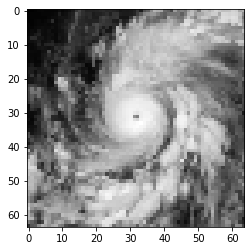

In [ ]:
plt.imshow(input[0][0][-1], cmap = "gray")

Output: 

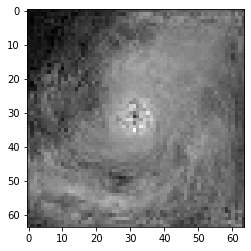

In [ ]:
plt.imshow(output[0][-1], cmap = 'gray')

### **Second Prediction**

Input:

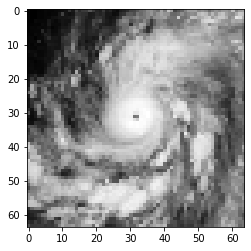

In [ ]:
plt.imshow(input[0][0][-2], cmap = "gray")

Output:

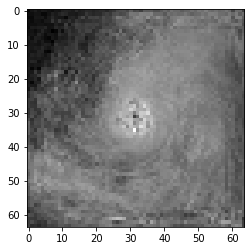

In [ ]:
plt.imshow(output[0][-2], cmap = 'gray')

### **Third Prediction**

Input:

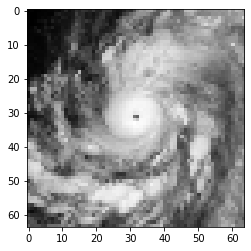

In [ ]:
plt.imshow(input[0][0][-3], cmap = "gray")

Output:

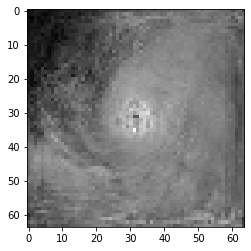

In [ ]:
plt.imshow(output[0][-3], cmap = 'gray')

### **Fourth Prediction**

Input:

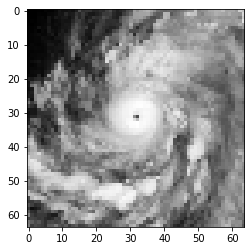

In [ ]:
plt.imshow(input[0][0][-4], cmap = "gray")

Output:

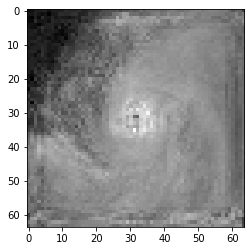

In [ ]:
plt.imshow(output[0][-4], cmap = 'gray')

### **Fifth Prediction**

Input:

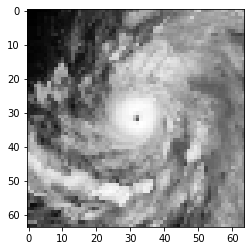

In [ ]:
plt.imshow(input[0][0][-5], cmap = "gray")

Output:

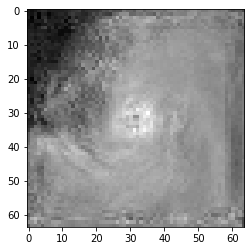

In [ ]:
plt.imshow(output[0][-5], cmap = 'gray')

## **Calculation of Final Metrics**

In [ ]:
# ------------------------------------------------------------------------------
# Load target images for comparison
# ------------------------------------------------------------------------------

target_1 = input[0][0][-5].cpu().detach().numpy()*255
target_2 = input[0][0][-4].cpu().detach().numpy()*255
target_3 = input[0][0][-3].cpu().detach().numpy()*255
target_4 = input[0][0][-2].cpu().detach().numpy()*255
target_5 = input[0][0][-1].cpu().detach().numpy()*255

predic_1 = output[0][-5]*255
predic_2 = output[0][-4]*255
predic_3 = output[0][-3]*255
predic_4 = output[0][-2]*255
predic_5 = output[0][-1]*255

# ------------------------------------------------------------------------------
# Scale predicted image to target range
# ------------------------------------------------------------------------------
predic_1 = scale2range(predic_1, [target_1.min(), target_1.max()])
predic_2 = scale2range(predic_2, [target_2.min(), target_2.max()])
predic_3 = scale2range(predic_3, [target_3.min(), target_3.max()])
predic_4 = scale2range(predic_4, [target_4.min(), target_4.max()])
predic_5 = scale2range(predic_5, [target_5.min(), target_5.max()])

# ------------------------------------------------------------------------------
# Cast to uint8 to accommodate for consistent SSIM and MSE results
# ------------------------------------------------------------------------------
target_1, predic_1 = target_1.astype(np.uint8), predic_1.astype(np.uint8)
target_2, predic_2 = target_2.astype(np.uint8), predic_2.astype(np.uint8)
target_3, predic_3 = target_3.astype(np.uint8), predic_3.astype(np.uint8)
target_4, predic_4 = target_4.astype(np.uint8), predic_4.astype(np.uint8)
target_5, predic_5 = target_5.astype(np.uint8), predic_5.astype(np.uint8)

# ------------------------------------------------------------------------------
# Sanity check
# ------------------------------------------------------------------------------
print(target_1.dtype, target_1.max(), target_1.min())
print(predic_1.dtype, predic_1.max(), predic_1.min())

# ------------------------------------------------------------------------------
# Compute metrics
# ------------------------------------------------------------------------------
print('\n ---------- SSIM and MSE values -------------- \n')
s_1, m_1 = ssim(target_1, predic_1), mse(target_1, predic_1)
s_2, m_2 = ssim(target_2, predic_2), mse(target_2, predic_2)
s_3, m_3 = ssim(target_3, predic_3), mse(target_3, predic_3)
s_4, m_4 = ssim(target_4, predic_4), mse(target_4, predic_4)
s_5, m_5 = ssim(target_5, predic_5), mse(target_5, predic_5)

# ------------------------------------------------------------------------------
print("First Prdiction : SSIM : ",s_5," MSE : ",m_5)
print("Second Prdiction : SSIM : ",s_4," MSE : ",m_4)
print("Third Prdiction : SSIM : ",s_3," MSE : ",m_3)
print("Fourth Prdiction : SSIM : ",s_2," MSE : ",m_2)
print("Fifth Prdiction : SSIM : ",s_1," MSE : ",m_1)

uint8 228 7
uint8 228 7

 ---------- SSIM and MSE values -------------- 

First Prdiction : SSIM :  0.2439177197073255  MSE :  1780.0048828125
Second Prdiction : SSIM :  0.23626908122418966  MSE :  1736.27587890625
Third Prdiction : SSIM :  0.18204864252112637  MSE :  1629.751708984375
Fourth Prdiction : SSIM :  0.16362045459587532  MSE :  1387.049072265625
Fifth Prdiction : SSIM :  0.15629322448560995  MSE :  1255.83251953125
